### Strong baseline : 0.81410
### ---Public : 0.77180, Private : 0.74417---
### Medium baseline : 0.52807
### Simple baseline : 0.44862
<br>
解題思路:<br>
因為上次發現loss曲線呈現overfitting的狀況，表示訓練集的圖片不夠多元<br>
所以這次我新增加IMAGENET的圖像增強技術和RandomErasing來使圖片變得更複雜<br>
然後我有嘗試RandomGrayscale，但最後的準確率反而掉下去了<br>
推測可能跟AutoAugment裡面的圖片轉換有衝突到<br>
<br>
另外我發現訓練到後期準確率久久才上升一次，可能是學習率太大<br>
然後我在想，我都使用Adam這種會動態調整學習率的optimizer了<br>
如果還用學習率衰減機制會不會很奇怪<br>
結果看了下Decoupled Weight Decay Regularization論文，說Adam+學習率衰減是可行的<br>
試了下發現效果非常顯著，不過我patience設定50太大了，下次試試30就好<br>

可以發現在162個epoch的時候，模型第一次進行學習率衰減，從1e-3降到1e-4<br>
曲線發生非常大的變化，說明學習率衰減機制是有必要的<br>

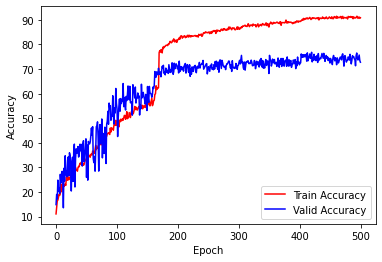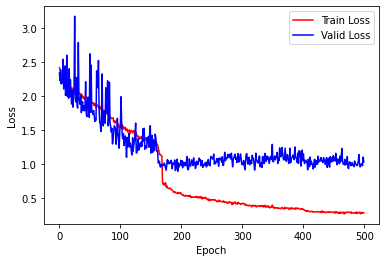

In [ ]:
# Import necessary packages.
import numpy as np
import torch
import torch.nn as nn
import torchvision.models as models
import torchvision.transforms as transforms
from PIL import Image
# "ConcatDataset" and "Subset" are possibly useful when doing semi-supervised learning.
from torch.utils.data import ConcatDataset, DataLoader, Subset
from torchvision.datasets import DatasetFolder

# This is for the progress bar.
from tqdm.auto import tqdm

import sys
sys.setrecursionlimit(1000000)

# the path where checkpoint saved
model_path = './model.ckpt'

myseed = 123  # set a random seed for reproducibility
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
np.random.seed(myseed)
torch.manual_seed(myseed)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(myseed)

In [ ]:
# It is important to do data augmentation in training.
# However, not every augmentation is useful.
# Please think about what kind of augmentation is helpful for food recognition.
train_tfm = transforms.Compose([
    transforms.RandomResizedCrop((128, 128)),
    transforms.RandomChoice(
        [transforms.AutoAugment(),
        transforms.AutoAugment(transforms.AutoAugmentPolicy.CIFAR10),
        transforms.AutoAugment(transforms.AutoAugmentPolicy.IMAGENET),
        transforms.AutoAugment(transforms.AutoAugmentPolicy.SVHN)]
    ),
    transforms.PILToTensor(),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.ColorJitter(brightness=0.5),
    #transforms.RandomGrayscale(p=0.5),
    transforms.RandomErasing(p=0.5),
    transforms.RandomRotation(15)
])

# We don't need augmentations in testing and validation.
# All we need here is to resize the PIL image and transform it into Tensor.
test_tfm = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.PILToTensor(),
])

因為我是用強制標記，所以我沒有對unlabeled_set做圖形增強(image augmentation)

In [ ]:
# Batch size for training, validation, and testing.
# A greater batch size usually gives a more stable gradient.
# But the GPU memory is limited, so please adjust it carefully.
batch_size = 32
test_batch_size = 512

# Construct datasets.
# The argument "loader" tells how torchvision reads the data.
train_set = DatasetFolder("../input/ml2021spring-hw3/food-11/training/labeled", loader=lambda x: Image.open(x), extensions="jpg", transform=train_tfm)
valid_set = DatasetFolder("../input/ml2021spring-hw3/food-11/validation", loader=lambda x: Image.open(x), extensions="jpg", transform=test_tfm)
unlabeled_set = DatasetFolder("../input/ml2021spring-hw3/food-11/training/unlabeled", loader=lambda x: Image.open(x), extensions="jpg", transform=test_tfm)
test_set = DatasetFolder("../input/ml2021spring-hw3/food-11/testing", loader=lambda x: Image.open(x), extensions="jpg", transform=test_tfm)

# Construct data loaders.
train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True, pin_memory=True)
valid_loader = DataLoader(valid_set, batch_size=test_batch_size, shuffle=True, pin_memory=True)
test_loader = DataLoader(test_set, batch_size=test_batch_size, shuffle=False)

因為用DatasetFolder包起來的對象不能進行刪除動作，而且unlabeled_set的的label也沒啥用(都是0)<br>
所以我就用一個list去打包我想要的部分就好，也方便進行刪除

In [ ]:
unlabeled_set_list = []

for img, _ in unlabeled_set:
    unlabeled_set_list.append(img)

In [ ]:
import gc

del valid_set, unlabeled_set, test_set
gc.collect()

In [ ]:
def get_pseudo_labels(model, threshold=0.95):
    global unlabeled_set_list, train_set
    
    remove_index, index = [], 0

    # This functions generates pseudo-labels of a dataset using given model.
    # It returns an instance of DatasetFolder containing images whose prediction confidences exceed a given threshold.
    # You are NOT allowed to use any models trained on external data for pseudo-labeling.
    device = "cuda" if torch.cuda.is_available() else "cpu"

    # Construct a data loader.
    #data_loader = DataLoader(dataset, batch_size=batch_size, shuffle=False)

    # Make sure the model is in eval mode.
    model.eval()
    # Define softmax function.
    softmax = nn.Softmax(dim=-1)

    # Iterate over the dataset by batches.
    for img in tqdm(unlabeled_set_list):

        # Forward the data
        # Using torch.no_grad() accelerates the forward process.
        with torch.no_grad():
            logits = model(torch.unsqueeze(img.float(), 0).to(device))

        # Obtain the probability distributions by applying softmax on logits.
        probs = softmax(logits)
        
        # ---------- TODO ----------
        # Filter the data and construct a new dataset.
        if torch.max(probs).item() > threshold:
            train_set = ConcatDataset([train_set, ([(img, torch.argmax(probs).item())])])
            remove_index.append(index)
        index += 1
      
    remove_index.reverse()
    for i in remove_index:
        del unlabeled_set_list[i]

    print(f"[{len(train_set)-3080}/6786] images have been labeled.")
    
    # # Turn off the eval mode.
    model.train()

我這邊的思路是當驗證集的acc高於0.7才去抓未標記的圖片<br>
然後當下一次的acc勝過之前的acc才會再做一次抓未標記的圖片的動作(你想想，如果你標記的圖片是對的，沒道理它的acc不會衝的比上一次更高)

In [ ]:
# "cuda" only when GPUs are available.
device = "cuda" if torch.cuda.is_available() else "cpu"

# Initialize a model, and put it on the device specified.
#model = Classifier().to(device)
model = models.resnet18(pretrained = False)
model.fc = nn.Linear(512, 11)
model.to(device)

# For the classification task, we use cross-entropy as the measurement of performance.
criterion = nn.CrossEntropyLoss()

# Initialize optimizer, you may fine-tune some hyperparameters such as learning rate on your own.
optimizer = torch.optim.RAdam(model.parameters(), lr=1e-3, weight_decay=1e-4)
#optimizer = torch.optim.SGD(model.parameters(), lr=0.1, momentum=0.9, weight_decay=1e-4) #原始resnet所使用的optimizer，很慢才收斂，之後嘗試看看
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', factor=0.1, patience=50, verbose=True)

# The number of training epochs.
n_epochs = 500
best_acc = 0

valid_acc_last = 0
valid_acc_threshold = 0.7

# Whether to do semi-supervised learning.
#do_semi = True

for epoch in range(n_epochs):
    # ---------- TODO ----------
    # In each epoch, relabel the unlabeled dataset for semi-supervised learning.
    # Then you can combine the labeled dataset and pseudo-labeled dataset for the training.
    if valid_acc_last > valid_acc_threshold:
        
        valid_acc_threshold = valid_acc_last
        
        # Obtain pseudo-labels for unlabeled data using trained model.
        if len(train_set) != 9866: #3080+6786
            get_pseudo_labels(model)

        # Construct a new dataset and a data loader for training.
        # This is used in semi-supervised learning only.
        train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True, pin_memory=True)

    # ---------- Training ----------
    # Make sure the model is in train mode before training.
    model.train()
    
    # These are used to record information in training.
    train_loss = []
    train_accs = []

    # Iterate the training set by batches.
    for batch in tqdm(train_loader):
        # A batch consists of image data and corresponding labels.
        imgs, labels = batch

        # Forward the data. (Make sure data and model are on the same device.)
        imgs = imgs.float()
        logits = model(imgs.to(device))
        
        # Calculate the cross-entropy loss.
        # We don't need to apply softmax before computing cross-entropy as it is done automatically.
        loss = criterion(logits, labels.to(device))

        # Gradients stored in the parameters in the previous step should be cleared out first.
        optimizer.zero_grad()

        # Compute the gradients for parameters.
        loss.backward()

        # Clip the gradient norms for stable training.
        grad_norm = nn.utils.clip_grad_norm_(model.parameters(), max_norm=10)

        # Update the parameters with computed gradients.
        optimizer.step()

        # Compute the accuracy for current batch.
        acc = (logits.argmax(dim=-1) == labels.to(device)).float().mean()

        # Record the loss and accuracy.
        train_loss.append(loss.item())
        train_accs.append(acc)

    # The average loss and accuracy of the training set is the average of the recorded values.
    train_loss = sum(train_loss) / len(train_loss)
    train_acc = sum(train_accs) / len(train_accs)

    # Print the information.
    print(f"[ Train | {epoch + 1:03d}/{n_epochs:03d} ] loss = {train_loss:.5f}, acc = {train_acc:.5f}")

    # ---------- Validation ----------
    # Make sure the model is in eval mode so that some modules like dropout are disabled and work normally.
    model.eval()

    # These are used to record information in validation.
    valid_loss = []
    valid_accs = []

    # Iterate the validation set by batches.
    for batch in tqdm(valid_loader):

        # A batch consists of image data and corresponding labels.
        imgs, labels = batch

        # We don't need gradient in validation.
        # Using torch.no_grad() accelerates the forward process.
        with torch.no_grad():
          imgs = imgs.float()
          logits = model(imgs.to(device))

        # We can still compute the loss (but not the gradient).
        loss = criterion(logits, labels.to(device))

        # Compute the accuracy for current batch.
        acc = (logits.argmax(dim=-1) == labels.to(device)).float().mean()

        # Record the loss and accuracy.
        valid_loss.append(loss.item())
        valid_accs.append(acc)

    # The average loss and accuracy for entire validation set is the average of the recorded values.
    valid_loss = sum(valid_loss) / len(valid_loss)
    valid_acc = sum(valid_accs) / len(valid_accs)
    valid_acc_last = valid_acc
    scheduler.step(valid_acc)

    # Print the information.
    print(f"[ Valid | {epoch + 1:03d}/{n_epochs:03d} ] loss = {valid_loss:.5f}, acc = {valid_acc:.5f}")
    
    if valid_acc > best_acc:
        best_acc = valid_acc
        torch.save(model.state_dict(), model_path)
        print('[{:03d}/{:03d}] saving model with acc {:.3f}'.format(epoch + 1, n_epochs, best_acc))

In [ ]:
model.load_state_dict(torch.load(model_path))

# Make sure the model is in eval mode.
# Some modules like Dropout or BatchNorm affect if the model is in training mode.
model.eval()

# Initialize a list to store the predictions.
predictions = []

# Iterate the testing set by batches.
for batch in tqdm(test_loader):
    # A batch consists of image data and corresponding labels.
    # But here the variable "labels" is useless since we do not have the ground-truth.
    # If printing out the labels, you will find that it is always 0.
    # This is because the wrapper (DatasetFolder) returns images and labels for each batch,
    # so we have to create fake labels to make it work normally.
    imgs, labels = batch

    # We don't need gradient in testing, and we don't even have labels to compute loss.
    # Using torch.no_grad() accelerates the forward process.
    with torch.no_grad():
        imgs = imgs.float()
        logits = model(imgs.to(device))

    # Take the class with greatest logit as prediction and record it.
    predictions.extend(logits.argmax(dim=-1).cpu().numpy().tolist())

In [ ]:
# Save predictions into the file.
with open("submission.csv", "w") as f:

    # The first row must be "Id, Category"
    f.write("Id,Category\n")

    # For the rest of the rows, each image id corresponds to a predicted class.
    for i, pred in  enumerate(predictions):
         f.write(f"{i},{pred}\n")